# Overview

# Import Modules

In [1]:
# magics
%load_ext autoreload
%autoreload 2
%matplotlib inline

# modules and settings
from __future__ import division
import os, sys
import sympy as sy
from IPython.display import display
from sympy.printing.str import StrPrinter
from hlfit.symbolic_functions import *
from hlfit.writers import write_constitutive_file

# start latex printing
sy.init_printing()

In [2]:
# variables
C1, C2, C3, C4, p = sy.symbols('C1 C2 C3 C4 p')
lamda, lamda1, lamda2, lamda3  = sy.symbols('lamda lamda1 lamda2 lamda3')
rho, rho0 = sy.symbols('rho rho0')
I1, I2, J = sy.symbols('I1 I2 J')
eps = sy.symbols(r'\varepsilon')

# identity
I = sy.Matrix.eye(3)

# Incompressible Hyperelastic Strain-Energy Functions

## Isotropic Models

Only evaluate the desired cell, or make a new one.

### Exponential-Type Models

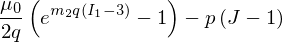

In [3]:
# rubin bodner model: elastic, with only first invariant
fname = 'constitutive_RubinBodner_I1'

# model basis
basis = 'invariants'

# setup parameters
C  = sy.Matrix([sy.symbols('mu0'), sy.symbols('q'), sy.symbols('m2')])

# simple purely elastic rubin bodner (C1 = mu0, C2=q, C3=m2)
g = C[2]*(I1 - 3)
W = C[0]/(2*C[1])*(sy.exp(C[1]*g) - 1)
W -= p*(J - 1)
W

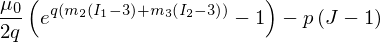

In [4]:
# rubin bodner model: elastic, with second invariant
fname = 'constitutive_RubinBodner_I1_I2'

# model basis
basis = 'invariants'

# setup parameters
C  = sy.Matrix([sy.symbols('mu0'), sy.symbols('q'), sy.symbols('m2'), sy.symbols('m3')])

# simple purely elastic rubin bodner (C1 = mu0, C2=q, C3=m2)
g = C[2]*(I1 - 3) + C[3]*(I2 - 3)
W = C[0]/(2*C[1])*(sy.exp(C[1]*g) - 1)
W -= p*(J - 1)
W

### Polynomial-Type Models

In [5]:
# neo-hooke model: abaqus
fname = 'constitutive_NeoHooke'

# model basis
basis = 'invariants'

# setup parameters
C  = sy.Matrix([C1])

# strain energy
W  = C[0]*(I1 - 3)
W -= p*(J - 1)
W

In [6]:
# neo-hooke model: abaqus
fname = 'constitutive_NeoHooke2'

# model basis
basis = 'invariants'

# setup parameters
C  = sy.Matrix([C1, C2])

# strain energy
W  = C[0]*(I1 - 3) + C[1]*(I1 - 3)**2
W -= p*(J - 1)
W

In [7]:
# mooney rivlin model: abaqus
fname = 'constitutive_MooneyRivlin'

# model basis
basis = 'invariants'

# setup parameters
C  = sy.Matrix([C1, C2])

# strain energy
W  = C[0]*(I1 - 3) + C[1]*(I2 - 3)
W -= p*(J - 1)
W

In [8]:
# mooney rivlin model: abaqus
fname = 'constitutive_POLY_100111'

# model basis
basis = 'invariants'

# setup parameters
C  = sy.Matrix([C1, C2, C3])

# strain energy
W  = C[0]*(I1 - 3) + C[1]*(I2 - 3) + C[2]*(I1 - 3)*(I2 - 3)
W -= p*(J - 1)
W

In [34]:
# general polynomial model: abaqus
N  = 2

# name it according to order
fname = 'constitutive_Poly' + str(N)

# model basis
basis = 'invariants'

# setup parameters
Cp = [[sy.symbols('C' + str(i) + str(j)) for i in range(N+1)] for j in range(N+1)]
C  = sy.Matrix([Ci for row in Cp for Ci in row][1:])

# strain energy
W  = sum([sum([Cp[i][j]*(I1 - 3)**i*(I2 - 3)**j for i in range(N+1)]) for j in range(N+1)])
W -= p*(J - 1)
W

### Ogden Models

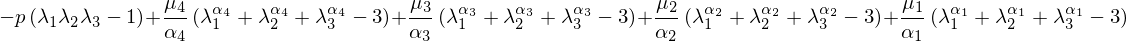

In [13]:
# ogden model: standard
N  = 4

# name it according to order
fname = 'constitutive_Ogden' + str(N)

# model basis
basis = 'stretches'

# setup parameters
mu = sy.Matrix([sy.symbols('mu' + str(i)) for i in range(1, N+1)])
al = sy.Matrix([sy.symbols('alpha' + str(i)) for i in range(1, N+1)])
C  = [(mui, ali) for mui, ali in zip(mu, al)]
C  = sy.Matrix([el for pair in C for el in pair])

# strain energy
W  = sum([mui/ali*(lamda1**ali + lamda2**ali + lamda3**ali - 3) for mui, ali in zip(mu, al)])
W -= p*(J - 1)
W  = W.subs([[J, lamda1*lamda2*lamda3]])
W

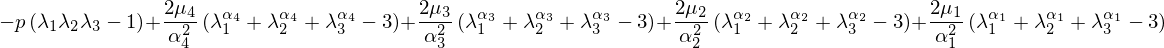

In [6]:
# ogden model: abaqus
N  = 4

# name it according to order
fname = 'constitutive_Ogden' + str(N) + '_ABQ'

# model basis
basis = 'stretches'

# setup parameters
mu = sy.Matrix([sy.symbols('mu' + str(i)) for i in range(1, N+1)])
al = sy.Matrix([sy.symbols('alpha' + str(i)) for i in range(1, N+1)])
C  = [(mui, ali) for mui, ali in zip(mu, al)]
C  = sy.Matrix([el for pair in C for el in pair])

# strain energy
W  = sum([2*mui/ali**2*(lamda1**ali + lamda2**ali + lamda3**ali - 3) for mui, ali in zip(mu, al)])
W -= p*(J - 1)
W  = W.subs([[J, lamda1*lamda2*lamda3]])
W

## Compute Constitutive Stresses
Compute stress tensors (here Cauchy and PK1) for three configurations. An undetermined term for the pressure remains, as here only incompressible materials are considered (constraint on the material).

In [14]:
# init dicts for kinematics
F     = dict()
e_val = dict()
e_vec = dict()

# configurations to consider
configs = ['UA', 'PS', 'EB']

for conf in configs:
    F[conf], e_val[conf], e_vec[conf] = set_deformation_gradient(conf)

# cauchy stress tensor
sig_cau = dict()
sig_pk1 = dict()

for conf in configs:
    sig_cau[conf] = get_cauchy_stress(W, F[conf], e_val[conf], e_vec[conf], mode=basis)
    sig_pk1[conf] = get_pk1_stress(W, F[conf], e_val[conf], e_vec[conf], mode=basis)

# diagonal components
sig_cau_ii = dict()
sig_pk1_ii = dict()

# diagonal compontens
for conf in configs:
    sig_cau_ii[conf] = sy.Matrix([sig_cau[conf][i, i].simplify() for i in range(3)])
    sig_pk1_ii[conf] = sy.Matrix([sig_pk1[conf][i, i].simplify() for i in range(3)])

## Boundary Conditions
All three experiment types are set up to have zero stress in the third direction. Using this condition, the "constitutively undetermined" pressure can be evaluated.

In [15]:
# zero stress boundary condition in third direction (it is irrelevant wheter this is obtained from cauchy or pk1, the results must coincide)
pressure = dict()

for conf in configs:
    pressure[conf], = sy.solve(sig_pk1_ii[conf][2], p)

## Principal Components
Using the calculated pressure, the principal components are evaluated. The first component always refers to the tensile direction (apart from equi-biaxial states where it is the same for two directions).

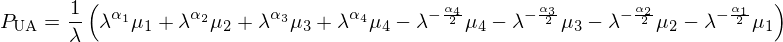

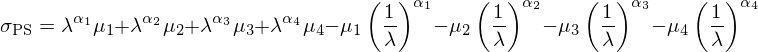

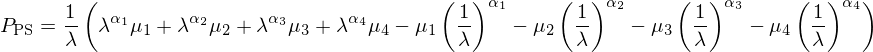

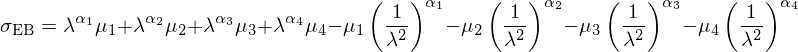

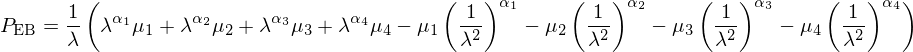

In [16]:
# store effective principal components
sig_cau_principal   = dict()
sig_pk1_principal   = dict()
d_sig_cau_principal = dict()
d_sig_pk1_principal = dict()

for conf in configs:
    sig_cau_principal[conf]   = [sig_cau[conf][i, i].subs({p:pressure[conf], rho:1}).simplify() for i in range(3)]
    sig_pk1_principal[conf]   = [sig_pk1[conf][i, i].subs({p:pressure[conf], rho:1}).simplify() for i in range(3)]
    
    sig_cau_principal[conf]   = sy.Matrix(sig_cau_principal[conf])
    sig_pk1_principal[conf]   = sy.Matrix(sig_pk1_principal[conf])
    
    # set parameter derivative (for jac)
    d_sig_cau_principal[conf] = sy.Matrix([sig_cau_principal[conf][0].diff(Ci).simplify() for Ci in C])
    d_sig_pk1_principal[conf] = sy.Matrix([sig_pk1_principal[conf][0].diff(Ci).simplify() for Ci in C])

# show stresses
display(sy.Eq(sy.symbols(r'\sigma_{\mathrm{UA}}'), sig_cau_principal['UA'][0]))
display(sy.Eq(sy.symbols(r'P_{\mathrm{UA}}'), sig_pk1_principal['UA'][0]))
display(sy.Eq(sy.symbols(r'\sigma_{\mathrm{PS}}'), sig_cau_principal['PS'][0]))
display(sy.Eq(sy.symbols(r'P_{\mathrm{PS}}'), sig_pk1_principal['PS'][0]))
display(sy.Eq(sy.symbols(r'\sigma_{\mathrm{EB}}'), sig_cau_principal['EB'][0]))
display(sy.Eq(sy.symbols(r'P_{\mathrm{EB}}'), sig_pk1_principal['EB'][0]))

# Linearization

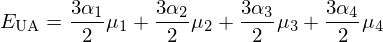

In [17]:
# linearization point
eps0 = 0

# store effective principal components
E_modulus = dict()

for conf in configs:
    s11 = sig_cau_principal[conf][0]
    s11_ofeps  = s11.subs({lamda:(1+eps)})
    d_s11_deps = s11_ofeps.diff(eps)
    E_modulus[conf] = d_s11_deps.subs({eps:eps0})

# show stresses
display(sy.Eq(sy.symbols(r'E_{\mathrm{UA}}'), E_modulus['UA']))
display(sy.Eq(sy.symbols(r'E_{\mathrm{PS}}'), E_modulus['PS']))
display(sy.Eq(sy.symbols(r'E_{\mathrm{EB}}'), E_modulus['EB']))

# Code Generation
Do **NOT** edit the following function, unless you want to risk disruptions in the aether and take responsability for the potential downfall of this particular universe.

In [18]:
write_constitutive_file(fname, C, sig_pk1_principal, sig_cau_principal, d_sig_pk1_principal, d_sig_cau_principal)

# Sigmoid Condition

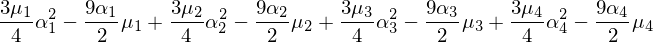

In [19]:
# set point
eps0 = 0

# force in incompressible uniaxial test with reference area = 1
f = sig_cau_principal['UA'][0]/lamda

# second derivative of force wrt to epsilon
ddf = f.subs({lamda:(eps+1)}).diff(eps, 2).subs({eps:eps0})
ddf.simplify()